# Notebook with CVAE model and conditionning over calendar features or temperature with bike sharing kaggle dataset

## Loading libraries

In [131]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images

In [132]:
#paths in git

#root git folder 
path_main_folder = '/home/goubetcle/Documents/CVAE/marota_cvae'
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_main_folder)
#add  to path source code folder
sys.path.append(path_main_folder+'/src')

In [326]:
#import class and methods from src
from keras import backend as K
from CVAE.callbacks import NEpochLogger,callbackWeightLoss
#from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE, CVAE_emb, CAE
from conso.load_shape_data import *  

import Visualisation.buildProjector
from Visualisation.buildProjector import *
from FeaturesScore.scoring import *
#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error
from sklearn.manifold import TSNE
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
#directories to store trained model and the related projector

log_dir_projector=path_main_folder+"/notebooks/logs/Expe-bike/CVAE_W_M_H/projector"
log_dir_model=path_main_folder+"/notebooks/logs/Expe-bike/CVAE_W_M_H//model"
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)

# Table of contents:
- Load Data
- Make Training Set
- Define and Train Model
- Build Projector
- Compute Feature Scores in latent space
- Study reconstruction Error
- Study Holidays prediction
- Detect atypical events
- Conclusion

## Load dataset

In [135]:
# Load dataframe
path_data = os.path.join(path_main_folder, 'data/bike-sharing')
dataset_train= os.path.join(path_data, "train.csv")
dataset_test= os.path.join(path_data, "test.csv")

train = pd.read_csv(dataset_train)
test = pd.read_csv(dataset_test)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [136]:
train.datetime = pd.to_datetime(train.datetime)

There is a day with only 12 hours of data. This day shall be removed.

In [137]:
dates, freq = np.unique(train.datetime.dt.date, return_counts=True)
target = dates[np.argmin(freq)]
ind = np.where(train.datetime.dt.date==target)[0]
train = train.drop(index=ind)

## Make training set of daily renting shares profiles and conditions

We use some conditions from expert knowledge we previosuly recovered (temperature, month, days of the week) to learn a new residual latent space.

In [138]:
timeserie = train.datetime.dt
nPoints = len(np.unique(timeserie.date))
nPoints

455

In [139]:
columns=train.columns
columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [232]:
x_conso = train[['datetime', 'count', 'temp', 'humidity', 'windspeed', 'holiday']].copy()
x_conso[['count', 'temp', 'humidity', 'windspeed', 'holiday']] = x_conso[['count', 'temp', 'humidity', 'windspeed', 'holiday']].astype('float64').values
x_conso = x_conso.rename(columns={'datetime':'ds', 'count':'consumption', 'temp':'temperature', 'holiday':'is_holiday_day'})
x_conso.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10874 entries, 0 to 10885
Data columns (total 6 columns):
ds                10874 non-null datetime64[ns]
consumption       10874 non-null float64
temperature       10874 non-null float64
humidity          10874 non-null float64
windspeed         10874 non-null float64
is_holiday_day    10874 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 594.7 KB


In [233]:
x_conso.describe()

,consumption,temperature,humidity,windspeed,is_holiday_day
count,10874.000000,10874.000000,10874.000000,10874.000000,10874.000000
mean,191.722733,20.243382,61.859665,12.802668,0.028600
std,181.183901,7.786752,19.238075,8.166106,0.166688
min,1.000000,0.820000,0.000000,0.000000,0.000000
25%,43.000000,13.940000,47.000000,7.001500,0.000000
50%,145.000000,20.500000,62.000000,12.998000,0.000000
75%,284.000000,26.240000,77.000000,16.997900,0.000000
max,977.000000,41.000000,100.000000,56.996900,1.000000


In [234]:
dict_xconso = {'train': x_conso}
name_set_plot = 'train'
version = '-v1'
# Normalize input variables
dict_xconso, _ = normalize_xconso(dict_xconso, type_scaler = 'standard', meteo_elements=['temperature', 'humidity', 'windspeed'])
dict_xconso['train'].describe()

['consumption']


,consumption,temperature,humidity,windspeed,is_holiday_day
count,1.087400e+04,1.087400e+04,1.087400e+04,1.087400e+04,10874.000000
mean,-4.181969e-17,-1.150042e-16,-8.886685e-17,9.409431e-17,0.028600
std,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,0.166688
min,-1.052696e+00,-2.494529e+00,-3.215629e+00,-1.567853e+00,0.000000
25%,-8.208763e-01,-8.095381e-01,-7.724447e-01,-7.104285e-01,0.000000
50%,-2.578865e-01,3.295719e-02,7.294971e-03,2.392095e-02,0.000000
75%,5.093251e-01,7.701406e-01,7.870346e-01,5.137608e-01,0.000000
max,4.334344e+00,2.665755e+00,1.982635e+00,5.412159e+00,1.000000


In [235]:
type_x = ['conso']
list_cond = ['day','month', 'temperature','humidity', 'windspeed']
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, list_cond=list_cond)

day (455, 7)
month (455, 12)
temperature (455, 24)
humidity (455, 24)
windspeed (455, 24)
(455, 91)


In [236]:
sum(dataset['train']['ds'].isna())

0

In [237]:
sum(np.isnan(dataset['train']['y']))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

def fill_nan(dataset, method='mean'):
    mask = np.isnan(dataset)
    if method == 'mean':
        dataset[mask]=np.ones(dataset.shape[0]).reshape(-1,1).dot(np.nanmean(dataset, axis=0).reshape(1,-1))[mask] #hours without information
    elif method == 'min':
        dataset[mask]=np.ones(dataset.shape[0]).reshape(-1,1).dot(np.nanmin(dataset, axis=0).reshape(1,-1))[mask] #hours without information


fill_nan(dataset['train']['x'][0], method='min')
fill_nan(dataset['train']['x'][1], method='mean')
sum(np.isnan(dataset['train']['x'][1]))

In [238]:
nPoints=dataset['train']['x'][1].shape[0]

#get conditions in array
days_emb =dataset['train']['x'][1][:,0:7]
month_emb =dataset['train']['x'][1][:,7:19]
temp_emb=dataset['train']['x'][1][:,19:43]
hum_emb=dataset['train']['x'][1][:,43:67]
wind_emb = dataset['train']['x'][1][:,67:]

to_emb=dataset['train']['x'][1]

x = dataset['train']['x'][0]

dataset['train']['x'] = [x,days_emb,month_emb, temp_emb, hum_emb, wind_emb]

In [329]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_holiday_day'].isna(),'is_holiday_day'] = 0

In [330]:
calendar_info.head(20)

,ds,month,weekday,is_weekday,is_holiday_day
0,2011-01-01,1,5,0,0.0
1,2011-01-02,1,6,0,0.0
2,2011-01-03,1,0,1,0.0
3,2011-01-04,1,1,1,0.0
4,2011-01-05,1,2,1,0.0
5,2011-01-06,1,3,1,0.0
6,2011-01-07,1,4,1,0.0
7,2011-01-08,1,5,0,0.0
8,2011-01-09,1,6,0,0.0
9,2011-01-10,1,0,1,0.0


In [331]:
dates = calendar_info['ds'].dt.date
weather = [train.weather.iloc[np.where(train['datetime'].dt.date==date)[0]].max() for date in dates]
calendar_info=calendar_info.join(pd.get_dummies(weather).rename(columns={1:'clear', 2:'mist', 3:'significant', 4:'extreme'}))
calendar_info.head()

,ds,month,weekday,is_weekday,is_holiday_day,clear,mist,significant,extreme
0,2011-01-01,1,5,0,0.0,0,0,1,0
1,2011-01-02,1,6,0,0.0,0,0,1,0
2,2011-01-03,1,0,1,0.0,1,0,0,0
3,2011-01-04,1,1,1,0.0,0,1,0,0
4,2011-01-05,1,2,1,0.0,1,0,0,0


In [332]:
calendar_info.describe()

,month,weekday,is_weekday,is_holiday_day,clear,mist,significant,extreme
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,6.512088,3.013187,0.709890,0.028571,0.224176,0.364835,0.408791,0.002198
std,3.449984,2.006554,0.454312,0.166782,0.417497,0.481914,0.492152,0.046881
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.500000,5.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,12.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Build and train model CVAE

In [161]:
#on sauvegarde le dataset
path_out = log_dir_model

In [244]:
# Parameters for autoencoder
e_dims=[24,18,12,6]#encoder dim
d_dims=[24,18,12,6]#decoder dim. Dense Blocks in skip connections can make the dimensions bigger when layers are concatenated with the previous one
to_emb_dim=[7,12,24,24,24] #input dimensions for conditions
cond_pre_dim = 0
input_dim = dataset['train']['x'][0].shape[1]
z_dim= 4
lambda_val = 0.04 #hyper-parameter which value was selected after cross-validation

In [245]:
name_model = 'cvae_sharings-W_M_T_1H-journalier'
#name_model = 'cvae_classification'

In [246]:
#if needs to relaod model classes after modification wothout restarting the kernel

import CVAE.cvae_model
import CVAE.callbacks
import importlib
importlib.reload(CVAE.cvae_model)
importlib.reload(CVAE.callbacks)

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [247]:
Lambda = K.variable(lambda_val, dtype='float32')
model = CVAE.cvae_model.CVAE_emb(input_dim=input_dim,
                  e_dims=e_dims, 
                  d_dims=d_dims, 
                  cond_pre_dim=cond_pre_dim,
                  z_dim=z_dim, 
                  beta=Lambda,
                  name=name_model, 
                  output=path_out,
                 to_emb_dim=to_emb_dim,
                 emb_dims=[[5,3],[6,3],[12,4],[12,4],[12,4]], emb_to_z_dim=[5,5],
                is_L2_Loss=False,has_BN=2)#these dimensions define the dimension layer of the conitional network

5
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb_input_0 (InputLayer)        (None, 7)            0                                            
__________________________________________________________________________________________________
emb_input_1 (InputLayer)        (None, 12)           0                                            
__________________________________________________________________________________________________
emb_input_2 (InputLayer)        (None, 24)           0                                            
__________________________________________________________________________________________________
emb_input_3 (InputLayer)        (None, 24)           0                                            
____________________________________________________________________________


## Training model

In [248]:
from keras.callbacks import TensorBoard
from time import time

#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)




--- START TRAINING ---

emb_input_0
emb_input_1
emb_input_2
emb_input_3
emb_input_4
[ 91.150665  83.956566 204.37416  106.59146 ]
12.936599275362317
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.577085  0.205387  0.210993        0.030769    -3.681465
random model    0.472325  0.125722  0.084205        0.061538    -5.874002
0 Epochs ...  - loss: 23.6868 - decoder_loss: 23.6539 - decoder_for_kl_loss: 0.8212 - val_loss: 21.7085 - val_decoder_loss: 21.6936 - val_decoder_for_kl_loss: 0.3722 val_loss 21.708492942478347 ... lambda Loss 0.03999999910593033
emb_input_0
emb_input_1
emb_input_2
emb_input_3
emb_input_4
[326.33713 257.98938 412.40488 472.9359 ]
13.217716666666664
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.968626  0.394853  0.153088        0.107692    -3.959007
random model    0.515345  0.127423  0.080038        0.000000    -6.202657
100 Epochs ...  - loss: 3.1696 - decoder_loss: 2.7888 

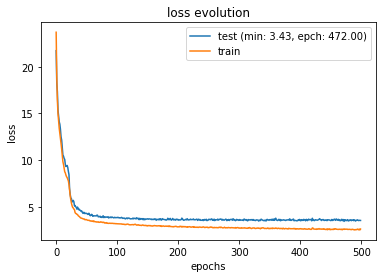

In [249]:
import warnings
warnings.filterwarnings('ignore')

lambda_decreaseRate=0.0
lambda_min=0.001 #p

#Turn it to True to train the model. Otherwise you can directly load on already trained model below
runTraining=True
runBatchCallback=True #In this callback we compute feature scores which is a bit long

if runTraining:#Training a neural network requires some computing power and the CPUs in MyBinder environment can be a bit slow. If you don't use callbacks it can be faster also 
    
    if runBatchCallback:
        out_batch = NEpochLogger(x_train_data=dataset['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
        model.main_train(dataset, training_epochs=500, batch_size=32, verbose=0,callbacks=[tensorboard,out_batch],validation_split=0.1)
    else:
        #use verbose=1 to see logs of training at every epoch
        model.main_train(dataset, training_epochs=500, batch_size=32, verbose=0,callbacks=[tensorboard],validation_split=0.1)




--- START TRAINING ---

emb_input_0
emb_input_1
emb_input_2
emb_input_3
emb_input_4
[221.63441   75.932655 380.21542  426.43475 ]
14.0161606060606
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.973650  0.382079  0.183599        0.046154    -5.112652
random model    0.456258  0.147092  0.065411        0.061538    -5.824948
0 Epochs ...  - loss: 2.5327 - decoder_loss: 2.2512 - decoder_for_kl_loss: 7.0382 - val_loss: 3.5831 - val_decoder_loss: 3.2851 - val_decoder_for_kl_loss: 7.4508 val_loss 3.583127384600432 ... lambda Loss 0.03999999910593033
emb_input_0
emb_input_1
emb_input_2
emb_input_3
emb_input_4
[161.31052   53.837646 384.9862   421.36777 ]
14.009076086956519
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.970734  0.362076  0.180171        0.030769    -5.285614
random model    0.451084  0.151130  0.081339        0.000000    -5.658372
100 Epochs ...  - loss: 2.4751 - decoder_loss: 2.2278 - d

emb_input_0
emb_input_1
emb_input_2
emb_input_3
emb_input_4
[ 11.975002   5.452835 400.86823  418.89352 ]
14.085847101449271
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.960551  0.432934  0.177305        0.030769    -4.864927
random model    0.499791  0.143496  0.084205        0.000000    -5.284316
1500 Epochs ...  - loss: 1.9806 - decoder_loss: 1.9045 - decoder_for_kl_loss: 8.5282 - val_loss: 3.3976 - val_decoder_loss: 3.3159 - val_decoder_for_kl_loss: 9.1691 val_loss 3.3976422703784444 ... lambda Loss 0.008918516337871552
emb_input_0
emb_input_1
emb_input_2
emb_input_3
emb_input_4
[ 24.18047    9.563629 401.49826  419.90497 ]
13.7599268115942
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.963011  0.420075  0.171011        0.046154    -4.900455
random model    0.467722  0.152513  0.075089        0.046154    -5.356685
1600 Epochs ...  - loss: 1.9488 - decoder_loss: 1.8798 - decoder_for_kl_loss: 

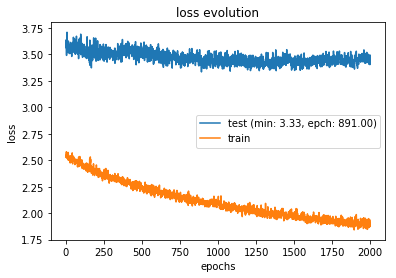

In [250]:
lambda_decreaseRate=0.001 #parameter by default

if runTraining:
    weightLoss=callbackWeightLoss(lambda_val,lambda_decreaseRate,lambda_min)
    if runBatchCallback:
        model.main_train(dataset, training_epochs=2000, batch_size=32, verbose=0,callbacks=[tensorboard,out_batch,weightLoss],validation_split=0.1)
    else:
        model.main_train(dataset, training_epochs=2000, batch_size=32, verbose=0,callbacks=[tensorboard,weightLoss],validation_split=0.1)


In [251]:
if runTraining:
    with open(os.path.join(log_dir_model,name_model,"config.txt"),'w') as file: 
        file.write(str(cond_pre_dim) + '\n')
        #file.write(str(emb_dims) + '\n')
        file.write(str(e_dims) + '\n') 
        file.write(str(d_dims) + '\n') 
        file.write(str(z_dim) + '\n')
        file.write(str(Lambda) + '\n')

In [252]:
#sauvegarde du dataset associé
if runTraining:
    name_dataset = 'dataset.pickle'

    with open( os.path.join(log_dir_model,name_model, name_dataset), "wb" ) as file:
        pickle.dump( dataset, file )

# Loading model

In [1]:
model.load_model(os.path.join(path_out, name_model, 'models'))

NameError: name 'model' is not defined

In [339]:
emb_inputs=[days_emb,month_emb,temp_emb, hum_emb, wind_emb]
emb_ouputs = model.embedding_enc.predict(emb_inputs)

#cond_pre=day_emb
#cond = np.concatenate((cond_pre, emb_ouputs), axis=1)
cond  = emb_ouputs
x_input = dataset['train']['x'][0]

input_encoder = [x_input,cond]

In [340]:
x_encoded = model.encoder.predict(input_encoder)[0]
x_hat = model.cvae.predict(x=dataset['train']['x'])[0]

# Analysis of the latent space with the construction of a tensorboard projector

In [333]:
includeConsumptionProfileImages=True #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
if includeConsumptionProfileImages:
    nPoints=min(1500,nPoints) #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
    x_encoded_reduced=x_encoded[0:nPoints,]
    images=createLoadProfileImages(x,x_hat,nPoints)
else:
    nPoints=nPoints

<Figure size 432x288 with 0 Axes>

In [334]:
if includeConsumptionProfileImages:
    sprites=images_to_sprite(images)
    cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)

In [335]:
writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
if includeConsumptionProfileImages:
    buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
else:
    buildProjector(x_encoded,images=None, log_dir=log_dir_projector)

In [336]:
log_dir_projector

'/home/goubetcle/Documents/CVAE/marota_cvae/notebooks/logs/Expe-bike/CVAE_W_M_H/projector'

# Predict Features in latent space

In [341]:
df_noCond_VAE=predictFeaturesInLatentSPace(x_conso,calendar_info,x_encoded)

13.780675296442674
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.960564  0.429324  0.149439        0.046154    -4.980842
random model    0.431117  0.102519  0.075000        0.030769    -5.754835


## Reconstsruction error analysis

In [342]:
error=np.sum(np.abs((x - x_hat)),axis=1)/24

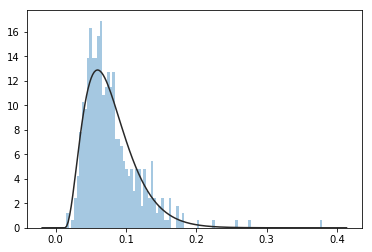

In [345]:
#make a histogram over residuals
import seaborn as sn
sn.distplot(error, kde=False, fit=stats.chi2, bins=100)

In [346]:
ErrorThreshold=0.18
idxMaxError=[i for i in range(0,nPoints) if error[i]>=ErrorThreshold]
calender_error=calendar_info.loc[idxMaxError]
calender_error['error']=error[idxMaxError]
print(len(calender_error))
calender_error

6


,ds,month,weekday,is_weekday,is_holiday_day,clear,mist,significant,extreme,error
380,2012-09-02,9,6,0,0.0,0,0,1,0,0.181569
410,2012-10-13,10,5,0,0.0,1,0,0,0,0.202045
412,2012-10-15,10,0,1,0.0,0,0,1,0,0.275666
416,2012-10-19,10,4,1,0.0,0,0,1,0,0.379402
423,2012-11-07,11,2,1,0.0,0,0,1,0,0.224312
429,2012-11-13,11,1,1,0.0,0,0,1,0,0.258670
